#  REGRESIÓN LOGÍSTICA 
 ***
 <code> **SELECCIÓN DE VARIABLES** </code>


En este Notebook se desarrollará la selección de variables del modelo de regresión logística.

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
import numpy as np

In [2]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

### 1. Importación de los datos

In [3]:
# Descargamos los datos en formato parquet de Google Drive
drive.descargar_archivos_concretos('datosEntrenamiento.parquet', '../../drive')

Archivo datosEntrenamiento.parquet guardado en: ../data/clean/datosEntrenamiento.parquet


In [4]:
data = pd.read_parquet('../data/clean/datosEntrenamiento.parquet')

In [5]:
data.head()

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def getYX(df):
    return df.iloc[:,0], df.iloc[:,1:]

In [7]:
def codificarPriceFormat(df):
    return pd.get_dummies(df, columns=['PriceFormat'], dtype = int)

In [8]:
# Semilla
SEED = 22

# Número de folds
CV_FOLDS = 5

### 2. Escalado robusto de variables numéricas

Para facilitar la convergencia del modelo, reducir los riesgos de sesgo y posteriormente poder comparar los coeficientes vamos a realizar un escalado robusto. Elegimos este tipo de escalado porque los datos no siguen distribuciones normales y tienen mucha presencia de datos atípicos. Como el escalado es menos sensible a problemas de *data leakage*, lo realizaremos al conjunto de datos entero, en vez de realizarlo una vez por iteración en validación cruzada.

In [9]:
data.columns[:20]

Index(['Bestseller', 'NumPages', 'SagaNumber', 'RedPerc', 'BluePerc',
       'BelongsSaga', 'Price', 'WordsTitle', 'PriceFormat', 'BookInterest1M',
       'Rating20Days', 'HasTwitter', 'HasWikipedia', 'PrevBestSellAuthor',
       '19th Century', '20th Century', 'Abuse', 'Action', 'Adoption', 'Adult'],
      dtype='object')

In [10]:
variablesNumericas = ['NumPages', 'SagaNumber', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

In [11]:
data[variablesNumericas].describe()

,NumPages,SagaNumber,RedPerc,BluePerc,Price,WordsTitle,BookInterest1M,Rating20Days,PrevBestSellAuthor
count,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000
mean,357.231215,1.795580,0.478141,0.425793,18.351773,3.297514,207.752762,4.111486,0.432597
std,118.630305,3.299657,0.229730,0.203802,5.650255,1.595152,418.554462,0.369079,3.253521
min,11.000000,0.000000,0.010000,0.010000,0.990000,1.000000,0.000000,2.000000,0.000000
25%,304.000000,1.000000,0.280000,0.260000,14.990000,2.000000,0.000000,3.870000,0.000000
50%,351.000000,1.000000,0.460000,0.400000,17.390000,3.000000,100.000000,4.140000,0.000000
75%,400.000000,1.000000,0.660000,0.580000,21.212500,4.000000,176.000000,4.370000,0.000000
max,2895.000000,58.000000,0.990000,0.940000,59.950000,14.000000,2911.000000,5.000000,48.000000


In [12]:
scaler = RobustScaler()

# Aplicamos el RobustScaler
for var in variablesNumericas:
    data[var] = scaler.fit_transform(data[var].values.reshape(-1, 1))

In [13]:
data[variablesNumericas].describe()

,NumPages,SagaNumber,RedPerc,BluePerc,Price,WordsTitle,BookInterest1M,Rating20Days,PrevBestSellAuthor
count,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000
mean,0.064908,0.795580,0.047739,0.080603,0.154564,0.148757,0.612232,-0.057028,0.432597
std,1.235732,3.299657,0.604553,0.636882,0.908036,0.797576,2.378150,0.738157,3.253521
min,-3.541667,-1.000000,-1.184211,-1.218750,-2.635597,-1.000000,-0.568182,-4.280000,0.000000
25%,-0.489583,0.000000,-0.473684,-0.437500,-0.385697,-0.500000,-0.568182,-0.540000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.510417,0.000000,0.526316,0.562500,0.614303,0.500000,0.431818,0.460000,0.000000
max,26.500000,57.000000,1.394737,1.687500,6.839695,5.500000,15.971591,1.720000,48.000000


### 3. Recursive feature elimination con validación cruzada

Vamos a realizar un RFE con validación cruzada para seleccionar el número óptimo de variables. Como hacer un pipeline con SMOTE-NC nos dio problemas, decidimos modificar la función de pérdida para equilibrar las clases.

In [14]:
from imblearn.pipeline import make_pipeline

In [15]:
def aplicarRFECV(X, y):
    
    MIN_FEATURES = 5
    METRICA = "balanced_accuracy"

    # Modelo de regresión logística
    modelo = LogisticRegression(max_iter = 5000, class_weight="balanced")

    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
   
    rfecv = RFECV(
        estimator=modelo,
        step=1,
        cv=cv,
        scoring=METRICA,
        min_features_to_select= MIN_FEATURES,
    )
    
    rfecv.fit(X, y)
    
    # Número óptimo de variables seleccionadas
    num_optimal_features = rfecv.n_features_
    print("Número óptimo de variables seleccionadas:", num_optimal_features)

    # Obtener índices de variables seleccionadas
    selected_feature_indices = rfecv.support_

    # Obtener nombres de variables seleccionadas
    selected_feature_names = [X.columns[i] for i, selected in enumerate(selected_feature_indices) if selected]
    
    # Tomado de https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("Media balanced accuracy en test")
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.show()
    
    return selected_feature_names

Número óptimo de variables seleccionadas: 222


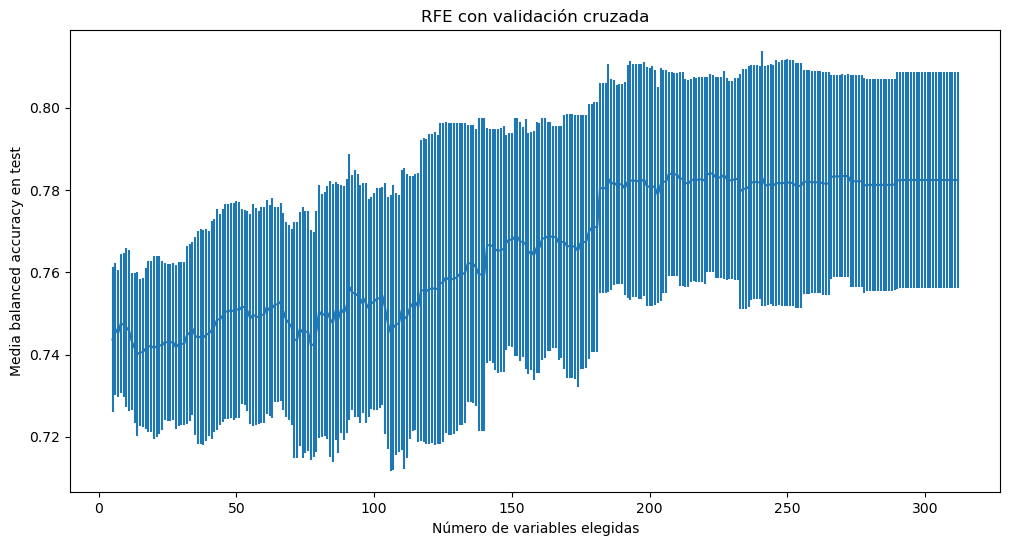

In [16]:
y, X = getYX(data)
X = codificarPriceFormat(X)

variablesElegidas = aplicarRFECV(X, y)

Podemos observar que empezamos con una balanced accuracy bastante buena (alrededor del 75%). Esta métrica aumenta conforme vamos agregando nuevas variables hasta estabilizarse en torno a las 222, que es el número óptimo seleccionado.

### 4. Variables descartadas

In [17]:
variablesDescartadas = [v for v in X.columns if v not in variablesElegidas]

In [18]:
print("--- VARIABLES SELECCIONADAS ---")
print(variablesElegidas)

print("--- VARIABLES DESCARTADAS ---")
print(variablesDescartadas)

--- VARIABLES SELECCIONADAS ---
['RedPerc', 'BluePerc', 'BelongsSaga', 'WordsTitle', 'BookInterest1M', 'HasTwitter', 'HasWikipedia', 'PrevBestSellAuthor', '19th Century', 'Abuse', 'Action', 'Adoption', 'Adult', 'Adult Fiction', 'Adventure', 'Africa', 'African American', 'African American Romance', 'African Literature', 'Amazon', 'American', 'Americana', 'Amish', 'Anthologies', 'Art', 'Asia', 'Asian Literature', 'Audiobook', 'Australia', 'BDSM', 'Banned Books', 'Biography Memoir', 'Book Club', 'Books About Books', 'Botswana', 'Boys Love', 'British Literature', 'Bulgaria', 'Bulgarian Literature', 'Chess', 'Chick Lit', 'Childrens', 'China', 'Christian Fiction', 'Christmas', 'Civil War', 'Classic Literature', 'Classics', 'Clean Romance', 'Climate Change', 'Climate Change Fiction', 'College', 'Comedy', 'Comic Book', 'Coming Of Age', 'Contemporary', 'Contemporary Romance', 'Cooking', 'Cozy Mystery', 'Crime', 'Cults', 'Cultural', 'Cyberpunk', 'Dark', 'Dark Fantasy', 'Death', 'Demons', 'Detect

Podemos observar que entre las variables descartadas se encuentran NumPages y SagaNumber, las cuales vimos que tenían una correlación muy baja con la variable respuesta.

In [19]:
# Variables que superaron el test chi2
superanChi2 = ['HasWikipedia',
 'Detective',
 'Classics',
 'Crime',
 'BelongsSaga',
 'Adventure',
 'Book Club',
 'Childrens',
 'Literature',
 'Spy Thriller',
 'Superheroes',
 'Dogs',
 'LGBT',
 'Science Fiction Fantasy',
 'Romance',
 'Contemporary',
 'Queer',
 'Contemporary Romance',
 'School',
 'Action',
 'Fantasy Romance',
 'Audiobook',
 'Polish Literature',
 'Russian Literature',
 'Botswana',
 'Military Science Fiction',
 'Realistic Fiction',
 'Horror',
 'Retellings',
 'Middle Grade',
 'Adult Fiction',
 'Gothic',
 'BDSM',
 'Westerns',
 'Military Fiction',
 'Adult',
 'Teen',
 'HasTwitter',
 'Post Apocalyptic',
 'PriceFormat_ebook',
 'Science Fiction',
 'Epic',
 'Plays',
 'Medieval',
 'Lesbian',
 'Chess',
 'Environment',
 'Classic Literature',
 'Horses',
 'Biography Memoir',
 'Banned Books',
 'Nursery Rhymes',
 'Parenting',
 'Star Wars',
 'Storytime',
 'Theatre',
 'Paranormal Romance',
 'Novella',
 'High Fantasy',
 'PriceFormat_paperback',
 'Abuse',
 'Russia',
 'Aliens',
 'Family',
 'Space Opera',
 'African American',
 'Angels',
 'Nature',
 'Boys Love',
 'Cozy Mystery',
 'Asian Literature',
 'Suspense',
 'Legal Thriller',
 'Young Adult Romance',
 'Mythology',
 'Africa',
 'American']

In [20]:
descartadasChi2 = [v for v in variablesDescartadas if v in superanChi2]
print(len(descartadasChi2))
print(descartadasChi2)

9
['Aliens', 'Angels', 'Horses', 'LGBT', 'Legal Thriller', 'Middle Grade', 'Paranormal Romance', 'Romance', 'Suspense']


En total, 9 de las variables descartadas superaban el test chi2 con respecto a la variable respuesta.

### 5. Almacenamos el nuevo conjunto de datos

In [21]:
data = pd.read_parquet("datosEntrenamientoModelosFinal.parquet")

In [22]:
# Quitamos PriceFormat codificado
variablesElegidasFinal = variablesElegidas[:-2]

variablesElegidasFinal.append("PriceFormat")
variablesElegidasFinal

['RedPerc',
 'BluePerc',
 'BelongsSaga',
 'WordsTitle',
 'BookInterest1M',
 'HasTwitter',
 'HasWikipedia',
 'PrevBestSellAuthor',
 '19th Century',
 'Abuse',
 'Action',
 'Adoption',
 'Adult',
 'Adult Fiction',
 'Adventure',
 'Africa',
 'African American',
 'African American Romance',
 'African Literature',
 'Amazon',
 'American',
 'Americana',
 'Amish',
 'Anthologies',
 'Art',
 'Asia',
 'Asian Literature',
 'Audiobook',
 'Australia',
 'BDSM',
 'Banned Books',
 'Biography Memoir',
 'Book Club',
 'Books About Books',
 'Botswana',
 'Boys Love',
 'British Literature',
 'Bulgaria',
 'Bulgarian Literature',
 'Chess',
 'Chick Lit',
 'Childrens',
 'China',
 'Christian Fiction',
 'Christmas',
 'Civil War',
 'Classic Literature',
 'Classics',
 'Clean Romance',
 'Climate Change',
 'Climate Change Fiction',
 'College',
 'Comedy',
 'Comic Book',
 'Coming Of Age',
 'Contemporary',
 'Contemporary Romance',
 'Cooking',
 'Cozy Mystery',
 'Crime',
 'Cults',
 'Cultural',
 'Cyberpunk',
 'Dark',
 'Dark Fant

In [23]:
datosFiltrados = data[["Bestseller"] + variablesElegidasFinal]
datosFiltrados

,Bestseller,RedPerc,BluePerc,BelongsSaga,WordsTitle,BookInterest1M,HasTwitter,HasWikipedia,PrevBestSellAuthor,19th Century,...,Whodunit,Witches,Womens,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,PriceFormat
0,0.0,0.51,0.40,0,1.0,0.0,1.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,paperback
1,0.0,0.61,0.54,1,2.0,0.0,1.0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,ebook
2,0.0,0.72,0.57,1,7.0,0.0,0.0,1.0,0.0,0,...,0,0,0,0,0,1,0,0,0,ebook
3,0.0,0.83,0.35,0,1.0,0.0,1.0,1.0,0.0,0,...,0,0,0,0,0,1,0,0,0,hardcover
4,0.0,0.59,0.26,0,4.0,0.0,0.0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,paperback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,0.0,0.40,0.38,1,5.0,100.0,1.0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,hardcover
3616,0.0,0.27,0.28,0,3.0,103.0,1.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,paperback
3617,0.0,0.10,0.16,0,5.0,0.0,1.0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,paperback
3618,0.0,0.51,0.43,0,3.0,590.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,hardcover


In [24]:
datosFiltrados.to_parquet("datosEntrenamientoRL.parquet", index = False)